# OPTIMIZATION BY 5x2 CV- `DecisionTreeClassifier` - ANALYSIS OF THE RESULT OF THE MULTIPLE `optuna` RUNS

In this notebook we analyse the results of the multiple runs with `optuna` and different, random 5x2 fold CV splits.

The aim is to confirm that the initially chosen model is a reasonable one.

## Modules and configuration

### Modules

In [113]:
import pickle

import sys

import pandas as pd
import numpy as np

from IPython.display import clear_output

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn.metrics import precision_score, make_scorer, classification_report, confusion_matrix

import optuna

import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})


### Configuration

In [121]:
#RANDOM_STATE = 11 # For reproducibility

#N = 250 # Number of experiments

OPT_RUNS_RESULTS_IN = "../data/ML_MODELS/Results_DecisionTree/Opt_DT_Scaled_OptRunsResults.csv"

IMG_FOLDER = './img/'

#S4_TRAIN_SET_IN = "../data/DATASETS_ML/S4_02_DS_AfterImputing_TrainTest_OVERSAMPLED_n3.csv"
S4_TRAIN_SET_IN = "../data/DATASETS_ML/S4_02_DS_AfterImputing_TrainTest.csv"
# Train/test set for S4 sample, all 112 features
S4_VALIDATION_SET_IN = "../data/DATASETS_ML/S4_02_DS_AfterImputing_Validation.csv"
# Validation set for S4 sample, all 112 features
CARMENES_SET_IN = "../data/DATASETS_ML/ML_02_DS_AfterImputing.csv"
# CARMENES ML sample, all 112 features

REL_FEATURES_IN = "../data/ML_MODELS/ML_pipeline_steps/Reliable_features.pickle"

FINAL_BEST_POSSIBLE_MODEL_OUT = "../data/ML_MODELS/Results_DecisionTree/DT_FinalBestModel.pickle"

LATEX_SIMILAR_MODELS_COUNT_OUT = "../data/ML_MODELS/Results_DecisionTree/DT_LaTeX_SimilarModels.tex"
LATEX_SIMILAR_MODELS_COUNT_OUT_DF = "../data/ML_MODELS/Results_DecisionTree/DT_LaTeX_SimilarModels_dfFormat.tex"



### Functions

In [42]:
def compare_dist(data, x_col, hue_col=None, varname=None,
                 xlim=None, ylim=None,
                 fig_title=None, fig_filename=None,
                 stat='count', kde=False, hist_fill=True, bins='auto'):
    '''Plots and saves overlapped histograms.
    Changed to use the new functions, instead of the deprecated "distplot"
    **NOTE: this would be better with a **kwargs argument'''
    # Plots and saves the figure
    #kwargs = dict(kde_kws={'linewidth': 2})
    #kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill},
    #              kde_kws={'linewidth': 2})
    #kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill})
    plt.figure(figsize=(10,7))
    ax = sns.histplot(data, x=x_col, hue=hue_col, stat=stat, common_norm=False,
                      kde=kde, fill=hist_fill, bins=bins, alpha=0.25)
    if varname is None:
        ax.set_xlabel(x_col, fontsize=12)
    else:
        ax.set_xlabel(varname, fontsize=12)
    if xlim is None:
        pass
    else:
        ax.set_xlim(xlim)
    if ylim is None:
        pass
    else:
        ax.set_ylim(ylim)
    
    if fig_title is None:
        ax.set_title("Comparison of distributions", fontsize=16)
    else:
        ax.set_title(fig_title, fontsize=16)
    #ax.set_ylabel('Frequency of occurrence', fontsize=12)
    #ax.legend(loc='best');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        ax.get_figure().savefig(fig_filename, format='jpg');

In [43]:
def draw_scatter_plot(data, x, y,
                      xlim=None, ylim=None,
                      fig_title=None, fig_filename=None, **kwargs):
    '''Draws and saves a scatter plot'''
    ax = sns.scatterplot(data, x=x, y=y, **kwargs)
    ax.figure.set_size_inches(15, 10)
    if xlim is None:
        curr_xlim = ax.get_xlim()
    else:
        curr_xlim = xlim
    new_xlim = (curr_xlim[0] - 0.05 * (curr_xlim[1] - curr_xlim[0]),
                curr_xlim[1] + 0.05 * (curr_xlim[1] - curr_xlim[0]))
    if ylim is None:
        curr_ylim = ax.get_ylim()
    else:
        curr_ylim = ylim
    new_ylim = (curr_ylim[0] - 0.05 * (curr_ylim[1] - curr_ylim[0]),
                curr_ylim[1] + 0.05 * (curr_ylim[1] - curr_ylim[0]))
    ax.set_xlim(new_xlim)
    ax.set_ylim(new_ylim)
    if fig_title is None:
        fig_title = "Scatter plot: '" + x + "' vs '" + y + "'"
    else:
        pass
    ax.set_title(fig_title, fontsize=16)
    ax.set_xlabel(x, fontsize=12)
    ax.set_ylabel(y, fontsize=12)
    ax.legend(title='Precision avg')
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='jpg');

In [44]:
def re_evaluate_model(model, X_train, y_train, X_val, y_val, refit=True):
    '''Reevaluates a model in the training and validation set'''
    if refit == True:
        model.fit(X_train, y_train)
    # Training score:
    y_train_pred = model.predict(X_train)
    tr_score = precision_score(y_train, y_train_pred, zero_division=0.0)
    # Validation score:
    y_val_pred = model.predict(X_val)
    val_score = precision_score(y_val, y_val_pred, zero_division=0.0)
    # Final depth of the tree:
    tree_depth = model.get_depth()
    
    return {'train_score': tr_score, 'validation_score': val_score, 'tree_depth': tree_depth}

## Load data

### Load results for multiple `optuna` runs

In [45]:
OPT_RUNS_RESULTS_IN

'../data/ML_MODELS/Results_DecisionTree/Opt_DT_Scaled_OptRunsResults.csv'

In [46]:
opt_val_results = pd.read_csv(OPT_RUNS_RESULTS_IN, sep=',', decimal='.')
opt_val_results

,Experiment_ID,Best_max_depth,Best_min_samples_leaf,Best_ccp_alpha,Best_average_precision_5x2CV,S4_traintest_precision,S4_validation_precision,Final_tree_depth
0,0,7,5,0.005,0.093205,0.875000,0.000000,7
1,1,8,5,0.015,0.114634,0.000000,0.000000,0
2,2,5,6,0.005,0.101115,0.857143,0.000000,5
3,3,7,5,0.015,0.119038,0.000000,0.000000,0
4,4,6,5,0.005,0.099076,0.842105,0.000000,6
...,...,...,...,...,...,...,...,...
245,245,6,7,0.005,0.105166,0.772727,0.000000,6
246,246,4,7,0.005,0.101323,0.857143,0.000000,4
247,247,8,7,0.005,0.112393,0.789474,0.076923,8
248,248,8,7,0.010,0.115760,0.533333,0.333333,4


## Analyze the results

### Maximum achievable validation precision

In [75]:
max_val_precision = opt_val_results['S4_validation_precision'].max()
max_val_precision

0.4285714285714285

Let's see how many of the combinations achieve this value:

In [76]:
opt_val_results[opt_val_results['S4_validation_precision'] == max_val_precision]

,Experiment_ID,Best_max_depth,Best_min_samples_leaf,Best_ccp_alpha,Best_average_precision_5x2CV,S4_traintest_precision,S4_validation_precision,Final_tree_depth
29,29,8,5,0.005,0.118234,0.794872,0.428571,8
88,88,8,5,0.005,0.107404,0.794872,0.428571,8
113,113,8,5,0.005,0.106245,0.794872,0.428571,8
216,216,8,5,0.005,0.130773,0.794872,0.428571,8


**OBSERVATION:** we get this pretty good result in only 4 instances.

We will better have a look at the distribution of best results for validation precision, to have an idea of what we really can achieve.

### Distribution of validation precisions

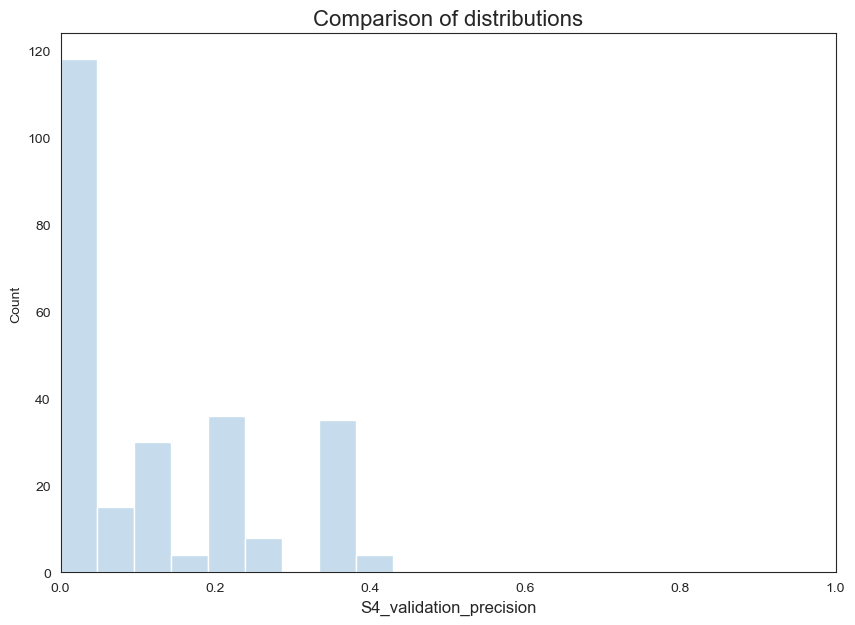

In [77]:
data = opt_val_results
x_col = 'S4_validation_precision'
hue_col = None
varname = None
xlim = (0.0, 1.0)
ylim = None
fig_title = None
fig_filename = None
stat='count'
kde=False
hist_fill=True
bins='auto'

compare_dist(
    data=data, x_col=x_col, hue_col=hue_col,
    varname=varname,
    xlim=xlim, ylim=ylim,
    fig_title=fig_title, fig_filename=fig_filename,
    stat=stat, kde=kde, hist_fill=hist_fill,
    bins=bins
)

**OBSERVATION:** As we can see, we have a lot of instances with $0$ validation precision.

In [78]:
val_precisions_count = opt_val_results[['S4_validation_precision', 'Experiment_ID']] \
    .groupby(by='S4_validation_precision').count() \
    .sort_values(by='Experiment_ID', ascending=False)
val_precisions_count

,Experiment_ID
S4_validation_precision,
0.000000,118
0.333333,29
0.200000,18
0.076923,15
0.100000,13
0.230769,10
0.214286,8
0.250000,8
0.111111,7


**OBSERVATION:** this is very interesting. The most frequent case is that in which validation precision is $0.00$ ($\sim50\%$ of the $250$ runs). The second more frequent one is the one with validation precision $0.33$ ($\sim12\%$ of the $250$ runs), and this is the value we got with the very first optimization.

Let's plot the distribution with the correct number of bins:

In [79]:
len(val_precisions_count)

14

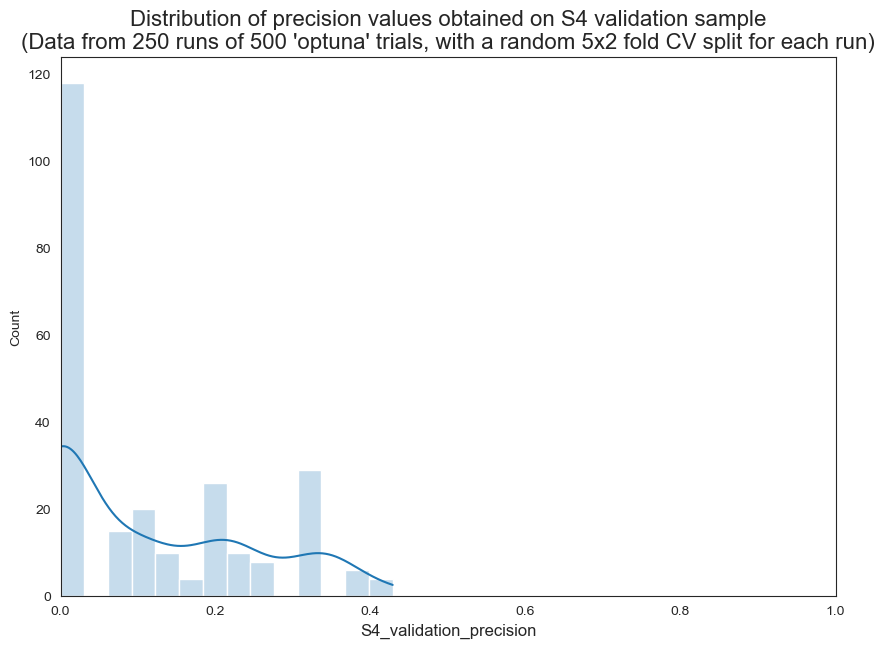

In [80]:
data = opt_val_results
x_col = 'S4_validation_precision'
hue_col = None
varname = None
xlim = (0.0, 1.0)
ylim = None
fig_title = "Distribution of precision values obtained on S4 validation sample\n" \
    "(Data from 250 runs of 500 'optuna' trials, with a random 5x2 fold CV split for each run)"
fig_filename = IMG_FOLDER + "ML_80_01_5x2_ValPrecisions_Distribution.jpg"
stat='count'
kde=True
hist_fill=True
bins = len(val_precisions_count)

compare_dist(
    data=data, x_col=x_col, hue_col=hue_col,
    varname=varname,
    xlim=xlim, ylim=ylim,
    fig_title=fig_title, fig_filename=fig_filename,
    stat=stat, kde=kde, hist_fill=hist_fill,
    bins=bins
)

Let's see with less bins:

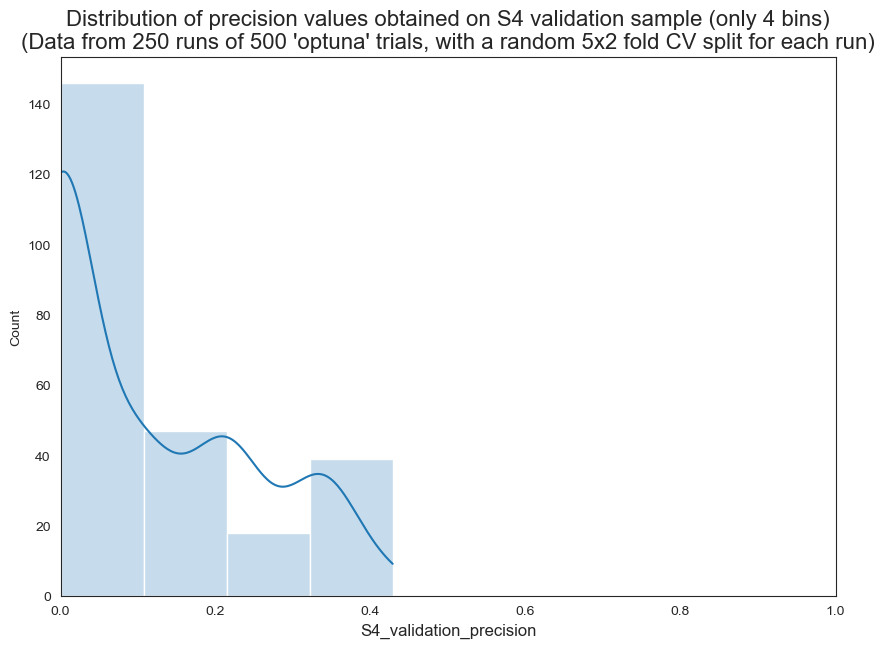

In [81]:
data = opt_val_results
x_col = 'S4_validation_precision'
hue_col = None
varname = None
xlim = (0.0, 1.0)
ylim = None
fig_title = "Distribution of precision values obtained on S4 validation sample (only 4 bins)\n" \
    "(Data from 250 runs of 500 'optuna' trials, with a random 5x2 fold CV split for each run)"
fig_filename = IMG_FOLDER + "ML_80_02_5x2_ValPrecisions_Distribution_4bins.jpg"
stat='count'
kde=True
hist_fill=True
bins = 4

compare_dist(
    data=data, x_col=x_col, hue_col=hue_col,
    varname=varname,
    xlim=xlim, ylim=ylim,
    fig_title=fig_title, fig_filename=fig_filename,
    stat=stat, kde=kde, hist_fill=hist_fill,
    bins=bins
)

**OBSERVATION:** the $0.00$ values could be just cases of overfitting during the , so we should discard them. Let's check the values they yielded for training/test set after final validation, and also the average precision obtained during 5x2 fold CV runs.

In [82]:
zero_val_precision = opt_val_results[opt_val_results['S4_validation_precision'] == 0.0].copy()
zero_val_precision

,Experiment_ID,Best_max_depth,Best_min_samples_leaf,Best_ccp_alpha,Best_average_precision_5x2CV,S4_traintest_precision,S4_validation_precision,Final_tree_depth
0,0,7,5,0.005,0.093205,0.875000,0.0,7
1,1,8,5,0.015,0.114634,0.000000,0.0,0
2,2,5,6,0.005,0.101115,0.857143,0.0,5
3,3,7,5,0.015,0.119038,0.000000,0.0,0
4,4,6,5,0.005,0.099076,0.842105,0.0,6
...,...,...,...,...,...,...,...,...
243,243,7,7,0.015,0.119167,0.000000,0.0,0
244,244,7,8,0.015,0.151786,0.000000,0.0,0
245,245,6,7,0.005,0.105166,0.772727,0.0,6
246,246,4,7,0.005,0.101323,0.857143,0.0,4


First, let's see the average precision achieved during 5x2 fold CV.

In [83]:
zero_val_precision[['Best_average_precision_5x2CV', 'Experiment_ID']] \
    .groupby(by='Best_average_precision_5x2CV').count()

,Experiment_ID
Best_average_precision_5x2CV,
0.083091,1
0.088487,1
0.088517,1
0.090530,1
0.090602,1
...,...
0.164030,1
0.166860,1
0.174255,1


Too many values, we need a graph:

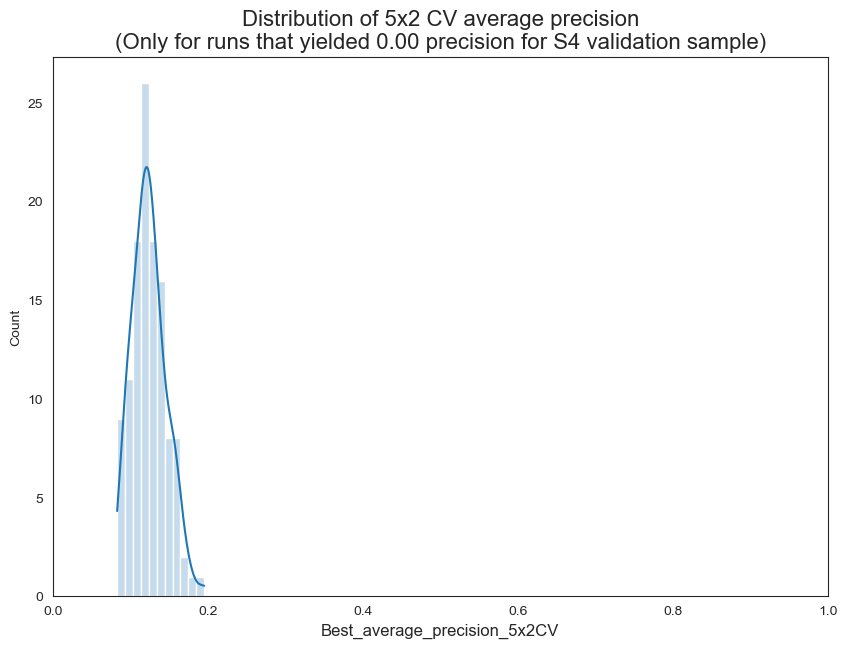

In [84]:
data = zero_val_precision
x_col = 'Best_average_precision_5x2CV'
hue_col = None
varname = None
xlim = (0.0, 1.0)
ylim = None
fig_title = "Distribution of 5x2 CV average precision\n" \
    "(Only for runs that yielded 0.00 precision for S4 validation sample)"
fig_filename = IMG_FOLDER + "ML_80_03_5x2_ValPrecisions_Distribution_OnlyZeroValPrec.jpg"
stat='count'
kde=True
hist_fill=True
bins = 'auto'

compare_dist(
    data=data, x_col=x_col, hue_col=hue_col,
    varname=varname,
    xlim=xlim, ylim=ylim,
    fig_title=fig_title, fig_filename=fig_filename,
    stat=stat, kde=kde, hist_fill=hist_fill,
    bins=bins
)

**OBSERVATION:** ok, it looks like precision is, in general, pretty bad for these cases. That is, these are bad models, for whatever reason.

Let's see the precisions for the train/test set.

In [85]:
zero_val_precision[['S4_traintest_precision', 'Experiment_ID']] \
    .groupby(by='S4_traintest_precision').count()

,Experiment_ID
S4_traintest_precision,
0.000000,31
0.704545,20
0.772727,22
0.842105,10
0.857143,23
0.875000,12


**OBSERVATION:** Ok, we have either $0.00$ values or very high values.

In short, we always have bad models: either they perform badly for all samples (5x2 CV splits, train/test and validation), or they severely overfit after the last retrain.

### Relationship between the three precisions values: 5x2 average, train/test and validation

Let's try to see the relationship between the three precision values with a scatter plot.

In [86]:
print(list(opt_val_results.columns))

['Experiment_ID', 'Best_max_depth', 'Best_min_samples_leaf', 'Best_ccp_alpha', 'Best_average_precision_5x2CV', 'S4_traintest_precision', 'S4_validation_precision', 'Final_tree_depth']


In [87]:
opt_val_results['S4_traintest_precision'].unique()

array([0.875     , 0.        , 0.85714286, 0.84210526, 0.70454545,
       0.6       , 0.79487179, 0.53333333, 0.78947368, 0.77272727,
       0.61111111, 0.60869565, 0.59459459, 0.56521739])

In [88]:
opt_val_results['S4_validation_precision'].unique()

array([0.        , 0.1       , 0.2       , 0.33333333, 0.07692308,
       0.18181818, 0.21428571, 0.42857143, 0.125     , 0.25      ,
       0.23076923, 0.375     , 0.11111111, 0.13333333])

In [89]:
(opt_val_results['S4_traintest_precision'] + opt_val_results['S4_validation_precision']).unique()

array([0.875     , 0.        , 0.85714286, 0.84210526, 0.70454545,
       0.7       , 0.99487179, 0.86666667, 0.86639676, 0.77272727,
       0.98947368, 0.97129187, 0.82539683, 1.22344322, 0.73611111,
       0.85869565, 0.83946488, 0.84188034, 1.16987179, 0.70570571,
       0.81521739, 0.74202899])

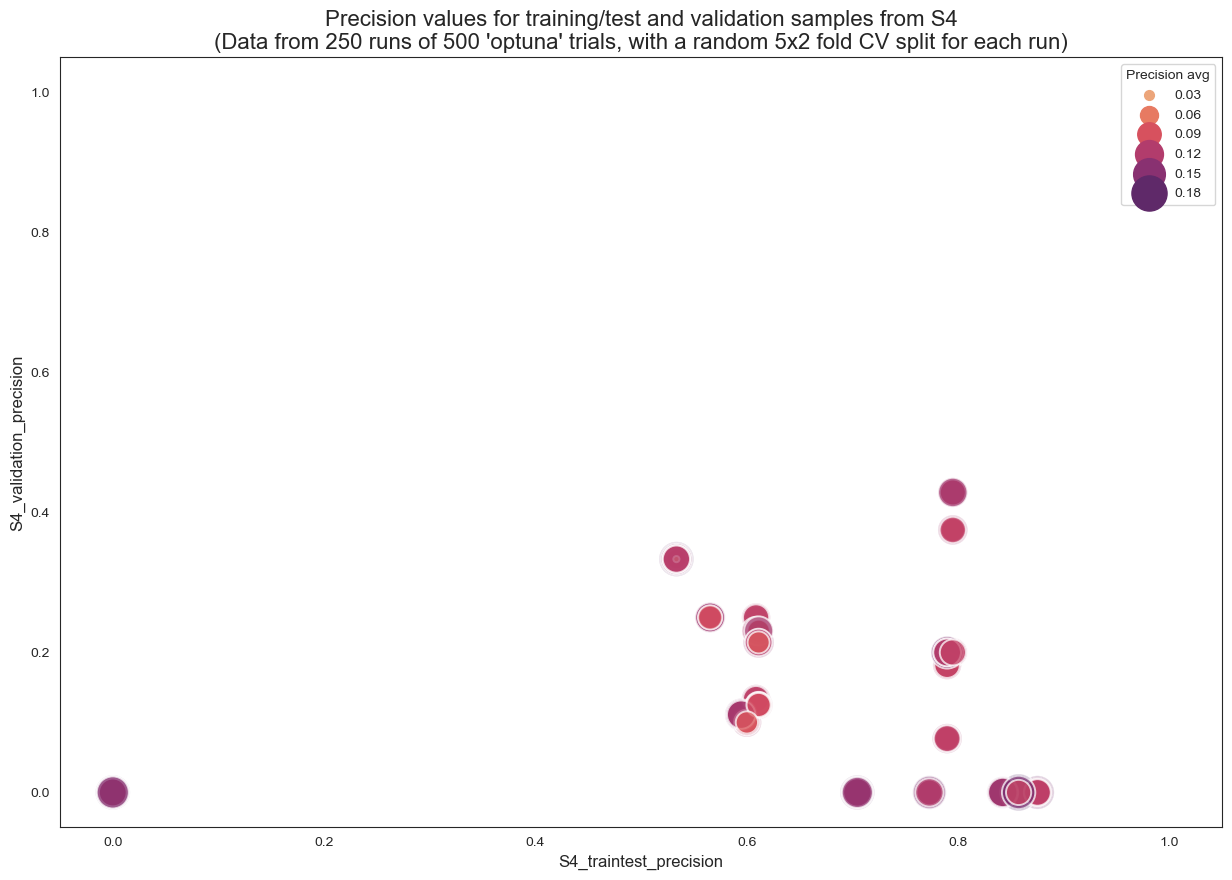

In [90]:
data = opt_val_results
x = 'S4_traintest_precision'
y = 'S4_validation_precision'
xlim = (0.0, 1.0)
ylim = (0.0, 1.0)
fig_title = "Precision values for training/test and validation samples from S4\n" \
    "(Data from 250 runs of 500 'optuna' trials, with a random 5x2 fold CV split for each run)"
fig_filename = IMG_FOLDER + "ML_80_04_AvgTrVal_Precisions_Relationship.jpg"
kwargs = {
    'hue': 'Best_average_precision_5x2CV',
    'size': 'Best_average_precision_5x2CV',
    'sizes': (20, 700),
    'alpha': 0.75,
    'palette': sns.color_palette("flare", as_cmap=True)
}

draw_scatter_plot(
    data=data, x=x, y=y,
    xlim=xlim, ylim=ylim,
    fig_title=fig_title, fig_filename=fig_filename,
    **kwargs
)

**OBSERVATIONS:** the most balanced point seems to be that around coordinates ($\sim0.53$, $\sim0.33$), that is, exactly the model that we first designed.

The two points around the top-right would be better. However, the number of runs that got those values are 

Hence, we can assume that our model is representetive of the results obtained in the run, and we can move forward with that model.

In [91]:
opt_val_results[opt_val_results['S4_validation_precision'] > 0.35]

,Experiment_ID,Best_max_depth,Best_min_samples_leaf,Best_ccp_alpha,Best_average_precision_5x2CV,S4_traintest_precision,S4_validation_precision,Final_tree_depth
29,29,8,5,0.005,0.118234,0.794872,0.428571,8
58,58,8,5,0.005,0.111461,0.794872,0.375000,8
70,70,8,5,0.005,0.109065,0.794872,0.375000,8
88,88,8,5,0.005,0.107404,0.794872,0.428571,8
113,113,8,5,0.005,0.106245,0.794872,0.428571,8
120,120,8,5,0.005,0.086126,0.794872,0.375000,8
135,135,8,5,0.005,0.133466,0.794872,0.375000,8
216,216,8,5,0.005,0.130773,0.794872,0.428571,8
223,223,8,5,0.005,0.097748,0.794872,0.375000,8
227,227,8,5,0.005,0.109556,0.794872,0.375000,8


### Similar models to the first one reached by `optuna`.

In [92]:
mask = (np.isclose(opt_val_results['S4_validation_precision'], 0.33, atol=0.01)) & \
    (np.isclose(opt_val_results['S4_traintest_precision'], 0.53, atol=0.01))
similar_models = opt_val_results[mask].copy()
similar_models

,Experiment_ID,Best_max_depth,Best_min_samples_leaf,Best_ccp_alpha,Best_average_precision_5x2CV,S4_traintest_precision,S4_validation_precision,Final_tree_depth
13,13,8,10,0.005,0.124172,0.533333,0.333333,8
26,26,6,7,0.010,0.113002,0.533333,0.333333,4
30,30,7,10,0.005,0.094202,0.533333,0.333333,7
50,50,6,9,0.005,0.118617,0.533333,0.333333,6
53,53,8,5,0.010,0.101489,0.533333,0.333333,4
56,56,4,5,0.010,0.175099,0.533333,0.333333,4
68,68,8,10,0.005,0.117752,0.533333,0.333333,8
73,73,8,9,0.010,0.127375,0.533333,0.333333,4
75,75,8,10,0.005,0.123898,0.533333,0.333333,8
77,77,8,10,0.005,0.125435,0.533333,0.333333,8


In [93]:
len(similar_models)

29

In [94]:
similar_models.drop(columns=['Experiment_ID']).describe()

,Best_max_depth,Best_min_samples_leaf,Best_ccp_alpha,Best_average_precision_5x2CV,S4_traintest_precision,S4_validation_precision,Final_tree_depth
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,6.965517,8.517241,0.006897,0.109759,0.533333,0.333333,5.896552
std,1.375364,1.805165,0.002469,0.027136,0.000000,0.000000,1.858279
min,4.000000,5.000000,0.005000,0.022496,0.533333,0.333333,4.000000
25%,6.000000,7.000000,0.005000,0.098801,0.533333,0.333333,4.000000
50%,8.000000,9.000000,0.005000,0.114382,0.533333,0.333333,6.000000
75%,8.000000,10.000000,0.010000,0.123898,0.533333,0.333333,8.000000
max,8.000000,10.000000,0.010000,0.175099,0.533333,0.333333,8.000000


In [95]:
print(list(similar_models.columns))

['Experiment_ID', 'Best_max_depth', 'Best_min_samples_leaf', 'Best_ccp_alpha', 'Best_average_precision_5x2CV', 'S4_traintest_precision', 'S4_validation_precision', 'Final_tree_depth']


In [105]:
similar_models_summary = similar_models[['Experiment_ID', 'Best_max_depth', 'Best_min_samples_leaf', 'Best_ccp_alpha', 'Final_tree_depth']] \
    .groupby(by=['Best_max_depth', 'Best_min_samples_leaf', 'Best_ccp_alpha', 'Final_tree_depth']).count() \
    .sort_values(by='Experiment_ID', ascending=False).rename(columns={'Experiment_ID': 'Count'})
similar_models_summary


Count
Best_max_depth Best_min_samples_leaf Best_ccp_alpha Final_tree_depth       
8              10                    0.005          8                    11
4              8                     0.005          4                     2
6              7                     0.010          4                     2
               9                     0.005          6                     2
               10                    0.005          6                     2
8              5                     0.010          4                     2
               9                     0.010          4                     2
4              5                     0.010          4                     1
5              6                     0.010          4                     1
7              6                     0.010          4                     1
               7                     0.010          4                     1
               10                    0.005          7                     1
8              7                     0.010          4                     1

#### Print and save `LaTeX` tables

In [122]:
# Print to screen:
print(similar_models_summary.to_latex(
    index=True, longtable=False,
    caption=(
        "Models with 0.53/0.33 precisions","Models with 0.53/0.33 precisions"
    )
))


\begin{table}
\centering
\caption[Models with 0.53/0.33 precisions]{Models with 0.53/0.33 precisions}
\begin{tabular}{llllr}
\toprule
  &    &       &   &  Count \\
Best\_max\_depth & Best\_min\_samples\_leaf & Best\_ccp\_alpha & Final\_tree\_depth &        \\
\midrule
8 & 10 & 0.005 & 8 &     11 \\
4 & 8  & 0.005 & 4 &      2 \\
6 & 7  & 0.010 & 4 &      2 \\
  & 9  & 0.005 & 6 &      2 \\
  & 10 & 0.005 & 6 &      2 \\
8 & 5  & 0.010 & 4 &      2 \\
  & 9  & 0.010 & 4 &      2 \\
4 & 5  & 0.010 & 4 &      1 \\
5 & 6  & 0.010 & 4 &      1 \\
7 & 6  & 0.010 & 4 &      1 \\
  & 7  & 0.010 & 4 &      1 \\
  & 10 & 0.005 & 7 &      1 \\
8 & 7  & 0.010 & 4 &      1 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\ciroe\AppData\Local\Temp\ipykernel_23604\2122417155.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(similar_models_summary.to_latex(


In [123]:
# Save to file:
# Write to file:
# Backup the standard output:
original_stdout = sys.stdout
with open(LATEX_SIMILAR_MODELS_COUNT_OUT, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(similar_models_summary.to_latex(
        index=True, longtable=False,
        caption=(
            "Models with 0.53/0.33 precisions","Models with 0.53/0.33 precisions"
        )
    ))
# Restore the standard output to its original value
sys.stdout = original_stdout

C:\Users\ciroe\AppData\Local\Temp\ipykernel_23604\2007531157.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(similar_models_summary.to_latex(


In [124]:
df_similar_models_summary = similar_models_summary.reset_index()
df_similar_models_summary

,Best_max_depth,Best_min_samples_leaf,Best_ccp_alpha,Final_tree_depth,Count
0,8,10,0.005,8,11
1,4,8,0.005,4,2
2,6,7,0.010,4,2
3,6,9,0.005,6,2
4,6,10,0.005,6,2
5,8,5,0.010,4,2
6,8,9,0.010,4,2
7,4,5,0.010,4,1
8,5,6,0.010,4,1
9,7,6,0.010,4,1


In [125]:
# Print to screen:
print(df_similar_models_summary.to_latex(
    index=False, longtable=False,
    caption=(
        "Models with 0.53/0.33 precisions","Models with 0.53/0.33 precisions"
    )
))


\begin{table}
\centering
\caption[Models with 0.53/0.33 precisions]{Models with 0.53/0.33 precisions}
\begin{tabular}{rrrrr}
\toprule
 Best\_max\_depth &  Best\_min\_samples\_leaf &  Best\_ccp\_alpha &  Final\_tree\_depth &  Count \\
\midrule
              8 &                     10 &           0.005 &                 8 &     11 \\
              4 &                      8 &           0.005 &                 4 &      2 \\
              6 &                      7 &           0.010 &                 4 &      2 \\
              6 &                      9 &           0.005 &                 6 &      2 \\
              6 &                     10 &           0.005 &                 6 &      2 \\
              8 &                      5 &           0.010 &                 4 &      2 \\
              8 &                      9 &           0.010 &                 4 &      2 \\
              4 &                      5 &           0.010 &                 4 &      1 \\
              5 &            

C:\Users\ciroe\AppData\Local\Temp\ipykernel_23604\2403374867.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_similar_models_summary.to_latex(


In [126]:
# Save to file:
# Write to file:
# Backup the standard output:
original_stdout = sys.stdout
with open(LATEX_SIMILAR_MODELS_COUNT_OUT_DF, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(df_similar_models_summary.to_latex(
        index=False, longtable=False,
        caption=(
            "Models with 0.53/0.33 precisions","Models with 0.53/0.33 precisions"
        )
    ))
# Restore the standard output to its original value
sys.stdout = original_stdout

C:\Users\ciroe\AppData\Local\Temp\ipykernel_23604\368146869.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_similar_models_summary.to_latex(


## Final evaluation of the supposedly better model

In [97]:
final_model = DecisionTreeClassifier(
    max_depth=8,
    min_samples_leaf=10,
    ccp_alpha=0.005,
    criterion='entropy', max_features=None,
    splitter='best'
)

### Performance

In [98]:
re_evaluate_model(
    model=final_model,
    X_train=train_set[rel_features], y_train=train_set['Pulsating'],
    X_val=val[rel_features], y_val=val['Pulsating'],
    refit=True
)

{'train_score': 0.5333333333333333,
 'validation_score': 0.3333333333333333,
 'tree_depth': 8}

**OBSERVATION:** Ok, it seems we get the expected results.

## Summary

**RESULTS:**

- We have analysed the results of the multiple runs of $500$ `optuna` trials, each run using a different 5x2 fold CV split.

**CONCLUSSION:**

- The model we have decided to use is a valid one.
- There seems to be several ways to reach those kind of models, although the majority of them uses these configuration:
    - 'max_depth': 8
    - 'min_samples_leaf': 10
    - 'ccp_alpha': 0.005
- And the final retraining yields a tree depth of 8 (i.e. it is not post-pruned)
